In [4]:
pip install efficientnet

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Activation, Dense,Flatten,Dropout
import efficientnet.tfkeras as efn 
import tensorflow
from nltk.corpus import wordnet as wn

In [6]:
target_size = (64, 64,3)
def load_and_proccess_image(id):
  # Load image, then scale and shift pixel values to [-0.5, 0.5]
  id=str(id)
  for i in range(12-len(id)):
    id='0'+id
  img = tensorflow.io.read_file('../input/coco2014/train2014/train2014/COCO_train2014_'+id+'.jpg')
  #img=img.resize((64,64))
  #im = img_to_array(img)
  #return im / 255 - 0.5
  img = tensorflow.image.decode_jpeg(img, channels=3)
  img = tensorflow.image.resize(img, (target_size[0],target_size[1]))
  img = efn.preprocess_input(img)
  return img


In [7]:
def wup_measure(word1,word2,similarity_threshold=0.9):
    word1_sem = wn.synsets(word1,pos=wn.NOUN)
    word2_sem = wn.synsets(word2,pos=wn.NOUN)
    score=0.0

    
    for x in word1_sem:
        for y in word2_sem:
            local_score=x.wup_similarity(y)
            if local_score > score:
                score=local_score

    
    if score < similarity_threshold:
        weight = 0.1
    else:
        weight = 1.0

    final_score = weight * score
    return final_score

def computeWups(answer_list,truth,similarity_threshold=0.9):
    score = 0
    for i in range(len(answer_list)):
        score += wup_measure(answer_list[i],truth[i],similarity_threshold)
    return (score / float(len(answer_list)))

## load

In [8]:
train=pd.read_csv('../input/full-qa/data_full.csv')

In [9]:
train.columns=['question','object','id']

In [10]:
train_question=train['question'].values
train_answer=train['object'].values
train_id=train['id'].values

In [104]:
#train_question=pd.read_csv('../input/qa-coco/data/questions.csv').values
#train_answer=pd.read_csv('../input/qa-coco/data/answers.csv').values
#train_id=pd.read_csv('../input/qa-coco/data/img_ids.csv').values

In [81]:
#train_type=pd.read_csv('../input/nlp-question/train_type.csv')

In [105]:
#train_answer=np.concatenate( train_answer[:20000], axis=0 )
#train_question=np.concatenate( train_question[:20000], axis=0 )
#train_id=np.concatenate( train_id[:20000], axis=0 )

In [83]:
#train_answer=train_answer[:10000]
#train_question=train_question[:10000]
#train_id=train_id[:10000]

In [11]:
ims=[]
for i in range(len(train_id)):
  id=train_id[i]
  ims.append(load_and_proccess_image(id))


In [12]:
del_index=[]
for k in range(len(train_id)):
    if ims[k].shape!=(64,64,3):
        del_index.append(k)
        
import cv2
import numpy as np
for j in del_index:
    gray = ims[j]
    ims[j] = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

In [13]:
all_answer=np.unique(train_answer)

In [14]:
train_X_ims = ims

In [15]:
from tensorflow.keras.utils import to_categorical

train_answer_indices = [all_answer.tolist().index(a) for a in train_answer]

train_Y = to_categorical(train_answer_indices)



In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_question)
total_words = len(tokenizer.word_index) + 1

In [17]:
input_sequences = []
for line in train_question:
    token_list = tokenizer.texts_to_sequences([line])[0]
    input_sequences.append(token_list)

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Model

In [105]:
#Creating the CNN model for image processing
from tensorflow.keras.layers import Multiply
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

#CNN_Input=tf.keras.layers.Input(shape=(64,64,3))
#CNN_model=tf.keras.applications.vgg16.VGG16(input_shape=(64,64,3), include_top=False,weights='imagenet')(CNN_Input)
#CNN_model= Flatten(name='flatten')(CNN_model)
#CNN_model= Dense(4096, activation='relu')(CNN_model)
#CNN_model= Dense(4096, activation='relu')(CNN_model)
#CNN_model= Dense(1024, activation='relu')(CNN_model)

CNN_Input=tf.keras.layers.Input(shape=(64,64,3),name='image_input')
CNN_model=tf.keras.models.Sequential()
CNN_model=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(64,64,3), alpha=1.0, include_top=False,weights='imagenet')(CNN_Input)
CNN_model=tf.keras.layers.GlobalAveragePooling2D()(CNN_model)
CNN_model= Dense(1024, activation='relu')(CNN_model)


vocab_size = len(tokenizer.word_index) + 1
shape=(vocab_size)

#Creating the RNN model for text processing
RNN_model=tf.keras.models.Sequential()

RNN_Input=tf.keras.layers.Input(shape=len(input_sequences[0]),name='text_input')
RNN_model=tf.keras.layers.Embedding(total_words, 100, input_length=max_sequence_len-1)(RNN_Input)
RNN_model=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform'))(RNN_model)
RNN_model=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform'))(RNN_model)
RNN_model=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform'))(RNN_model)
RNN_model= Dense(1024, activation='tanh')(RNN_model)

In [106]:
from tensorflow.keras.layers import Multiply
out = Multiply()([CNN_model, RNN_model])
out = Dense(1000, activation='tanh')(out)
# num_answers will be defined below
out = Dense(len(all_answer), activation='softmax')(out)

In [107]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
model = Model(inputs=[CNN_Input, RNN_Input], outputs=out)
model.compile(
  Adam(lr=2e-5),
  loss='categorical_crossentropy',
  metrics=['accuracy'],)

In [108]:
train_X_seqs=input_sequences

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_val, X_seqs_train, X_seqs_val, Y_train, Y_val = train_test_split(train_X_ims, train_X_seqs,train_Y ,test_size=0.1)

In [118]:
import tensorflow as tf
X_train=tf.stack(X_train)
X_val=tf.stack(X_val)


In [111]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [124]:
history=model.fit(
  [X_train, X_seqs_train],
  Y_train,
  validation_data=([X_val, X_seqs_val], Y_val),
  shuffle=True,
  epochs=30,steps_per_epoch=100, validation_steps=100,callbacks=[es_callback] 
)

Epoch 1/30
100/100 [==============================] - 38s 284ms/step - loss: 5.7718 - accuracy: 0.0501 - val_loss: 4.7502 - val_accuracy: 0.0812
Epoch 2/30
100/100 [==============================] - 25s 250ms/step - loss: 4.5785 - accuracy: 0.1011 - val_loss: 4.5842 - val_accuracy: 0.1161
Epoch 3/30
100/100 [==============================] - 25s 247ms/step - loss: 4.2432 - accuracy: 0.1702 - val_loss: 4.1664 - val_accuracy: 0.1641
Epoch 4/30
100/100 [==============================] - 25s 247ms/step - loss: 3.7184 - accuracy: 0.2268 - val_loss: 3.7310 - val_accuracy: 0.1997
Epoch 5/30
100/100 [==============================] - 25s 247ms/step - loss: 3.3503 - accuracy: 0.2847 - val_loss: 3.5575 - val_accuracy: 0.2208
Epoch 6/30
100/100 [==============================] - 25s 250ms/step - loss: 3.0868 - accuracy: 0.3320 - val_loss: 3.4464 - val_accuracy: 0.2383
Epoch 7/30
100/100 [==============================] - 25s 246ms/step - loss: 2.9052 - accuracy: 0.3592 - val_loss: 3.3410 - val_ac

In [54]:
model.save('all_V2_34.h5')
import pickle
pickle.dump(tokenizer, open("all_V2_34.pkl", "wb"))

In [55]:
len(input_sequences[0])

41

In [56]:
len(all_answer)

429

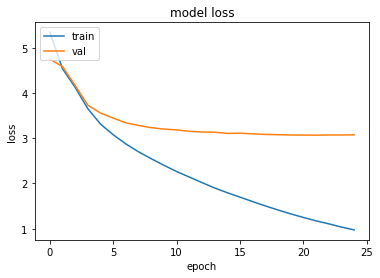

In [125]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [127]:
pred1=np.argmax(model.predict([X_val[:2000],X_seqs_val[:2000]],steps=1), axis=1)
pred2=np.argmax(model.predict([X_val[2000:],X_seqs_val[2000:]],steps=1), axis=1)


In [128]:
pred=np.concatenate((pred1, pred2))

In [129]:
y_pred=[]
y_val=[]
for p in range(len(pred)):
    y_pred.append(all_answer[pred[p]])
    y_val.append(all_answer[np.argmax(Y_val[p])])

In [130]:
computeWups(y_pred,y_val,0.9)

0.44486850019123414

In [131]:
computeWups(y_pred,y_val,0.0)

0.815991517754938